In [93]:
import librosa
import matplotlib.pyplot as plt
import numpy as np

%matplotlib widget

wave_files = [
    "speech1.wav",
    "speech2.wav"
]

**1 Fundamental frequency estimation by eye**

1a) Load the wave files from the archive. What is the sampling frequency of the signals?

In [95]:
def get_sampling_freq(path):
    _, sampling_rate = librosa.load(path, sr=None)
    print(f"The sampling frequency of file '{path}' is {sampling_rate} Hz.")

for file in wave_files:
    get_sampling_freq(file)

The sampling frequency of file 'speech1.wav' is 16000 Hz.
The sampling frequency of file 'speech2.wav' is 16000 Hz.


b) Plot the signal as a function of time [s]. For this, create a vector which contains the time instants for each sample. For plotting, you can employ the plot command from matplotlib.pyplot

Identify the voiced, unvoiced and silence regions in the waveform. Which criteria did you use to
distinguish between the three signal types?

Filename: 'speech1.wav'
Sampling rate: 16000 Hz
Length: 2.841625 s


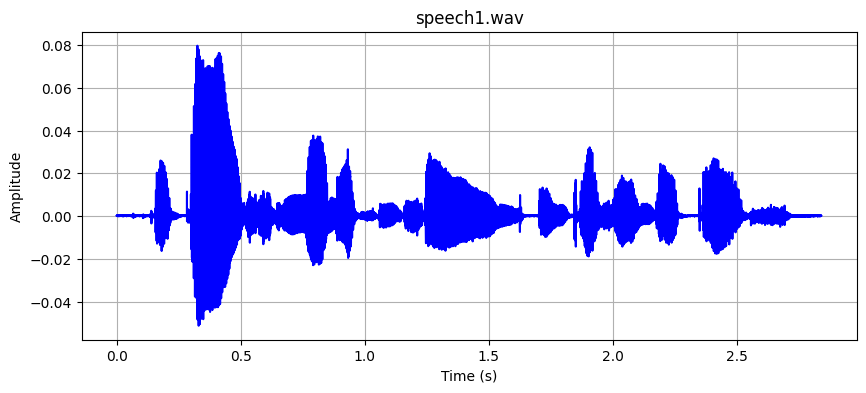

Filename: 'speech2.wav'
Sampling rate: 16000 Hz
Length: 2.8608125 s


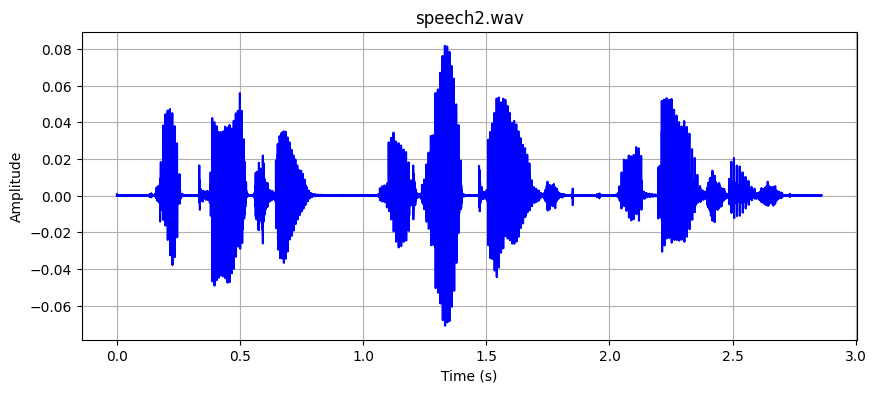

In [96]:
def plot_signal(path: str):
    print(f"Filename: '{path}'")
    y, sr = librosa.load(path, sr=None)

    print(f"Sampling rate: {sr} Hz")
    print(f"Length: {len(y)/sr} s")

    # create a vector which contains the time instants for each sample
    time = np.arange(0, len(y)) / sr

    # create the plot
    plt.figure(figsize=(10, 4))
    plt.plot(time, y, color='b')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(path)
    plt.grid(True)
    plt.show()

plot_signal(wave_files[0])
plot_signal(wave_files[1])


c) Pick a single voiced segment from both signals and estimate the fundamental frequency from the waveform.
The results measured this way may be helpful to verify the outcomes of the fundamental frequency estimator
in part 3 of the exercise.

Plot your selected segments and describe your procedure. Judging based on the measured fundamental
frequencies, do the signals originate rather from a male or a female speaker? Verify your findings by
listening to the signals! (In the following exercises you should be able to listen to audio data contained
in numpy (abbreviated with np) arrays. For this you could use the play function from sounddevice.)

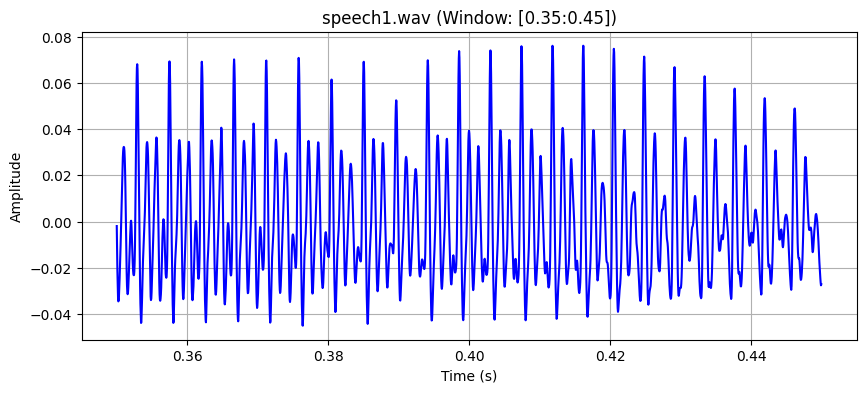

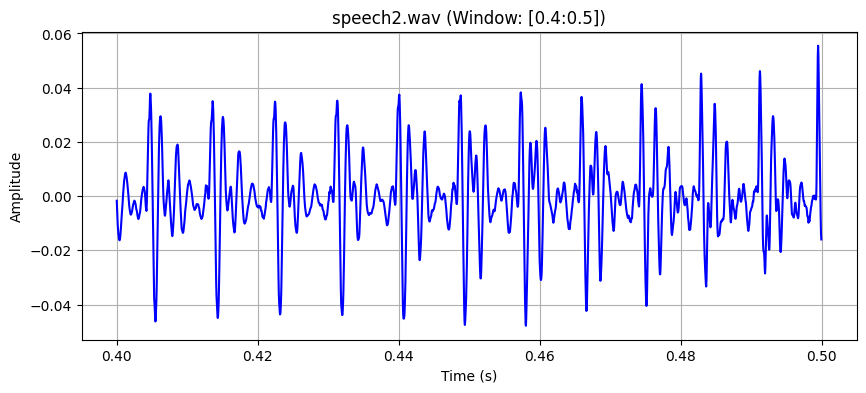

In [97]:
def plot_window(path, start, end):
    y, sr = librosa.load(path)

    # create a vector which contains the time instants for each sample
    y1 = int(start * sr)
    y2 = int(end * sr)

    time = np.arange(y1, y2) / sr

    # create the plot
    plt.figure(figsize=(10, 4))
    plt.plot(time, y[y1:y2], color='b')
    plt.xlabel(f'Time (s)')
    plt.ylabel('Amplitude')
    plt.title(f"{path} (Window: [{start}:{end}])")
    plt.grid(True)
    plt.show()

plot_window(wave_files[0], 0.35, 0.45)
plot_window(wave_files[1], 0.4, 0.5)

In [89]:
print(f"Window size: 0.02 s")
print(f"Plot 1: {4 * 50} Hz")
print(f"Plot 2: {2 * 50} Hz")

Window size: 0.02 s
Plot 1: 200 Hz
Plot 2: 100 Hz


**2 Block processing**

Write your own Python function that splits the time domain signal into overlapping frames. A prototype for this
function could look like the following example assuming that the loaded signal is stored in the vector v_signal.
def my_windowing(v_signal: np.ndarray , sampling_rate: int , frame_length: int ,
frame_shift: int) -> [np.ndarray (m_frames), np.ndarray (v_time_frame)]
The parameter sampling_rate is the sampling rate in Hz, while frame_length and frame_shift should contain
the frame length and the frame shift in units of milliseconds. The extracted segments are stored in the rows of
the matrix m_frames. The elements of the vector v_time_frame correspond to the time instants around which the
frames are centered.

In how many frames can the input signal be split? Try to find a formula for computing the number of
frames from the signal length, frame length and frame shift.

In [90]:
def my_windowing(v_signal: np.ndarray, sampling_rate: int, frame_length: int, frame_shift: int) -> tuple[np.ndarray, np.ndarray]:
    samples_per_frame = int(sampling_rate * frame_length / 1000)
    samples_per_shift = int(sampling_rate * frame_shift / 1000)
    
    N = len(v_signal)
    num_frames = int(np.ceil((N - samples_per_frame) / samples_per_shift)) + 1
    
    m_frames = np.zeros((num_frames, samples_per_frame))
    v_time_frame = np.zeros(num_frames)
    
    for i in range(num_frames):
        start = i * samples_per_shift
        end = start + samples_per_frame
        if end <= N:
            m_frames[i, :] = v_signal[start:end]
        else:
            m_frames[i, :N-start] = v_signal[start:N]
        v_time_frame[i] = (start + samples_per_frame / 2) / sampling_rate
    
    return m_frames, v_time_frame

y, sr = librosa.load(wave_files[0], sr=None)




**3 Fundamental frequency estimator**
In this part of the exercise a fundamental frequency estimator will be implemented which operates on the
overlapping frames from the previous exercise. The estimator is based on the autocorrelation function (ACF)
which will be computed on every frame. This function indicates how similar a block is to a shifted version of
itself. This way the time period between the glottal impulses can be identified which allows for estimating the
fundamental frequency

a) Split the signal into 32 ms frames with a frame shift of 16 ms using your function from Section 2.
b) Compute the ACF for every frame using np.convolve which computes the convolution. Think about how the
indices of the resulting ACF correspond to the lag τ.
c) Remove the lower half of the ACF which corresponds to the negative lags.
d) Estimate the fundamental frequency by selecting the maximum in the remaining part of the ACF. The search
range should be limited to frequencies between 80 Hz and 400 Hz, so the maximum at τ = 0 ms will not be
identified as period length. Remember that the detected maximum corresponds to the period length!
e) Plot the time course of the estimated fundamental frequencies together with the time domain signal.
•In which parts of the signal does the fundamental frequency estimator give reasonable results and why?
Do the estimated frequencies match your findings from the first exercise in Section 1?

In [98]:
def estimate_fundamental_frequencies(v_signal, sampling_rate, frame_length_ms=32, frame_shift_ms=16):
    # Step a: Split the signal into frames
    frames, frame_times = my_windowing(v_signal, sampling_rate, frame_length_ms, frame_shift_ms)
    
    fundamental_freqs = []
    
    # Step b: Compute ACF for each frame and step d: Estimate fundamental frequency
    for frame in frames:
        # ACF via convolution
        acf = np.convolve(frame, frame[::-1], mode='full')
        
        # Step c: Focus on non-negative lags
        acf = acf[len(acf)//2:]
        
        # Convert frequency range to corresponding lag range
        min_lag = sampling_rate // 400  # Maximum frequency
        max_lag = sampling_rate // 80   # Minimum frequency
                
        # Step d: Identify peak within the lag range corresponding to 80 Hz to 400 Hz
        peak_lag = np.argmax(acf[min_lag:max_lag]) + min_lag
        fundamental_freq = sampling_rate / peak_lag
        
        fundamental_freqs.append(fundamental_freq)
    
    return np.array(fundamental_freqs), frame_times

/tmp/ipykernel_4034/1559354517.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


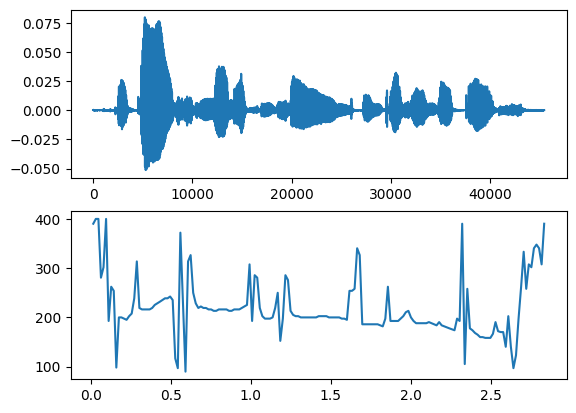

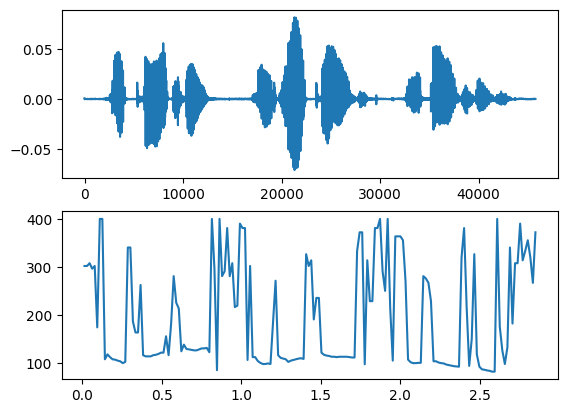

In [111]:
for file in wave_files:
    v_signal, sampling_rate = librosa.load(file, sr=None)
    fundamental_freqs, frame_times = estimate_fundamental_frequencies(v_signal, sampling_rate)

    fig, (ax1, ax2) = plt.subplots(2,1, sharey=False)
    ax1.plot(np.arange(len(v_signal)), v_signal)
    ax2.plot(frame_times, fundamental_freqs)
    fig.show()
    # Step e: Plot the estimated fundamental frequencies
    # plt.figure(figsize=(12, 6))
    # plt.plot(frame_times, fundamental_freqs, label='Estimated Fundamental Frequency')
    # plt.xlabel('Time (s)')
    # plt.ylabel('Frequency (Hz)')
    # plt.title(f'Estimated Fundamental Frequencies Over Time: {file}')
    # plt.legend()
    # plt.show()